In [1]:
# Load some of the new LF tuning data

# Load the HF datasets

# Compute metrics assessing similarity of any two datasets

In [2]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from laser_tuning.src.utils.utils_gg_combustor import extract_laser_fwhm, extract_laser_geometry, extract_laser_focal_location

In [3]:

def extract_meta_df_hf(runs: list) -> pd.DataFrame:

    rows = []

    for run in runs:
        parts = run.stem.split('_')
        alpha = float(parts[0][5:])
        beta = float(parts[1][4:])
        timestep = int(parts[-1])
        sim_time = extract_sim_time_hf(run)

        rows.append({
            'run_name': run,
            'alpha': alpha,
            'beta': beta,
            'timestep': timestep,
            'sim_time': sim_time
        })

    # Set index to run_name
    df = pd.DataFrame(rows)
    df.set_index('run_name', inplace=True)
    return df



def extract_sim_time_hf(run: pathlib.Path) -> float:
    """Return simulation time in microseconds
    """
    sim_time = np.load(run)['simTime']
    sim_time *= 4.477124  # Multiply by time scale to get units of [us]
    return sim_time


def extract_temp_arr(run_name: pathlib.Path):
    data = np.load(run_name)
    return data['temperature'] * 300
    
    
def extract_spatial_coords(run_name: pathlib.Path):
    data = np.load(run_name)
    return data['position'] * 1.25  # Multiply by spatial scale to get units of [mm]


In [4]:
data_dir = pathlib.Path('/Volumes/My Passport for Mac/laser_tuning/HF')
runs = sorted(data_dir.glob('*.npz'))
assert len(runs) > 0, 'No runs found in directory'

df = extract_meta_df_hf(runs)
df

,alpha,beta,timestep,sim_time
run_name,,,,
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.0_beta1.35_data_00000.npz,2.0,1.35,0,0.0
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.0_beta1.35_data_00500.npz,2.0,1.35,500,5.1311144627144225
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.0_beta1.35_data_01000.npz,2.0,1.35,1000,10.566074424877147
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.0_beta1.35_data_01500.npz,2.0,1.35,1500,16.067483868157
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.0_beta1.35_data_02000.npz,2.0,1.35,2000,21.669469759597877
...,...,...,...,...
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.4_beta1.35_data_09500.npz,2.4,1.35,9500,170.40093574077298
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.4_beta1.35_data_10000.npz,2.4,1.35,10000,184.3244613972391
/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.4_beta1.35_data_10500.npz,2.4,1.35,10500,198.55576635106414


/Volumes/My Passport for Mac/laser_tuning/HF/alpha2.0_beta1.35_data_10000.npz
Temperature array shape: (176, 220, 176)


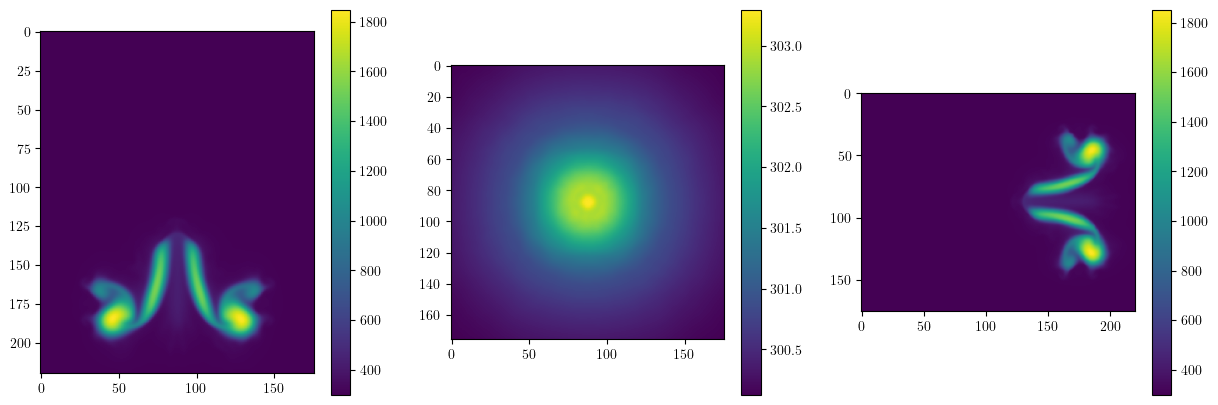

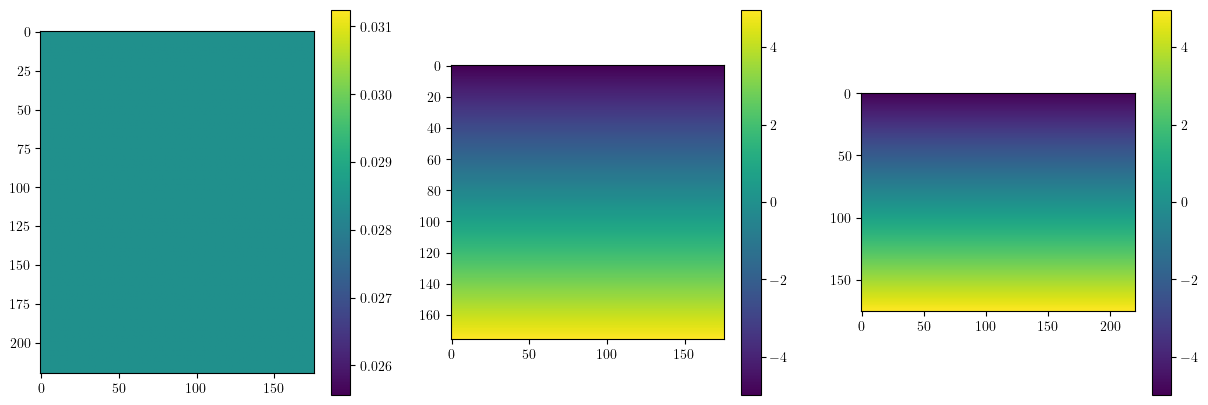

In [5]:
# In this cell we explore loading the data and extracting coordinates of each cell

test_filename_hf = df.iloc[20, :].name
print(test_filename_hf)


temp_arr = extract_temp_arr(test_filename_hf)
spatial_coords = extract_spatial_coords(test_filename_hf)

def plot_3_slice(arr):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        arr_slice = np.take(arr, indices=arr.shape[i]//2, axis=i)
        im = ax[i].imshow(arr_slice)
        plt.colorbar(im, ax=ax[i])
        ax[i].set_aspect('equal')
    plt.show()
    
print(f"Temperature array shape: {temp_arr.shape}")
plot_3_slice(temp_arr)
plot_3_slice(spatial_coords[:, :, :, 2])

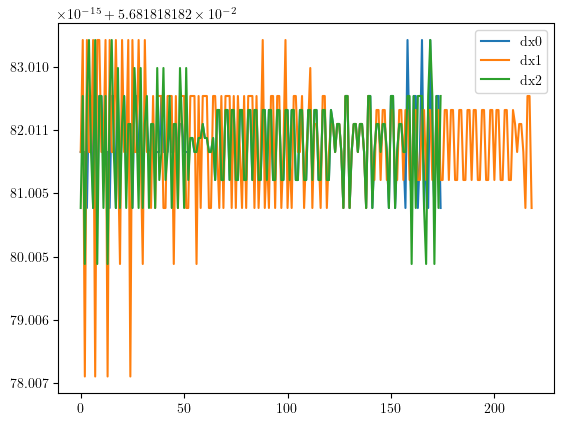

In [6]:
# Grid spacing
dx0s = np.diff(spatial_coords[:, 0, 0, 2])
dx1s = np.diff(spatial_coords[0, :, 0, 1])
dx2s = np.diff(spatial_coords[0, 0, :, 0])

plt.plot(dx0s, label='dx0')
plt.plot(dx1s, label='dx1')
plt.plot(dx2s, label='dx2')
plt.legend()
plt.show()

In [7]:
dx0s[0]

0.05681818181818166

In [8]:
from laser_tuning.src.utils.plotting_utils import write_isosurface_plot_from_arr

write_isosurface_plot_from_arr(temp_arr, 'test.png', 1000.0, False)

In [9]:
# In order to easily compare LF and HF data, let's load them both into xarray DataArrays

import xarray as xr

x_coords = spatial_coords[:, 0, 0, 2] 
y_coords = spatial_coords[0, :, 0, 1]
z_coords = spatial_coords[0, 0, :, 0]

# Create the DataArray
data_array = xr.DataArray(
    temp_arr,
    coords={
        'x [mm]': x_coords,
        'y [mm]': y_coords,
        'z [mm]': z_coords
    },
    dims=['x [mm]', 'y [mm]', 'z [mm]'],
    name='temperature'
)

print(data_array)



<xarray.DataArray 'temperature' (x [mm]: 176, y [mm]: 220, z [mm]: 176)> Size: 55MB
array([[[300.02234793, 300.02229073, 300.0224706 , ..., 300.02109266,
         300.02141572, 300.02165677],
        [300.02203634, 300.02167001, 300.0219013 , ..., 300.02136106,
         300.02186348, 300.02148509],
        [300.02215734, 300.02230768, 300.02254113, ..., 300.02137346,
         300.02160526, 300.0219542 ],
        ...,
        [300.16152729, 300.16494725, 300.17090914, ..., 300.17006362,
         300.1653741 , 300.16002255],
        [300.15931506, 300.16333448, 300.16782041, ..., 300.1667882 ,
         300.16228145, 300.15772699],
        [300.15806532, 300.16227482, 300.16554829, ..., 300.16376788,
         300.15934971, 300.15560593]],

       [[300.02191585, 300.02202097, 300.02216609, ..., 300.02067192,
         300.0210612 , 300.02125109],
        [300.02162725, 300.0215118 , 300.02210898, ..., 300.02127414,
         300.02164826, 300.02166792],
        [300.02213928, 300.02225175, 

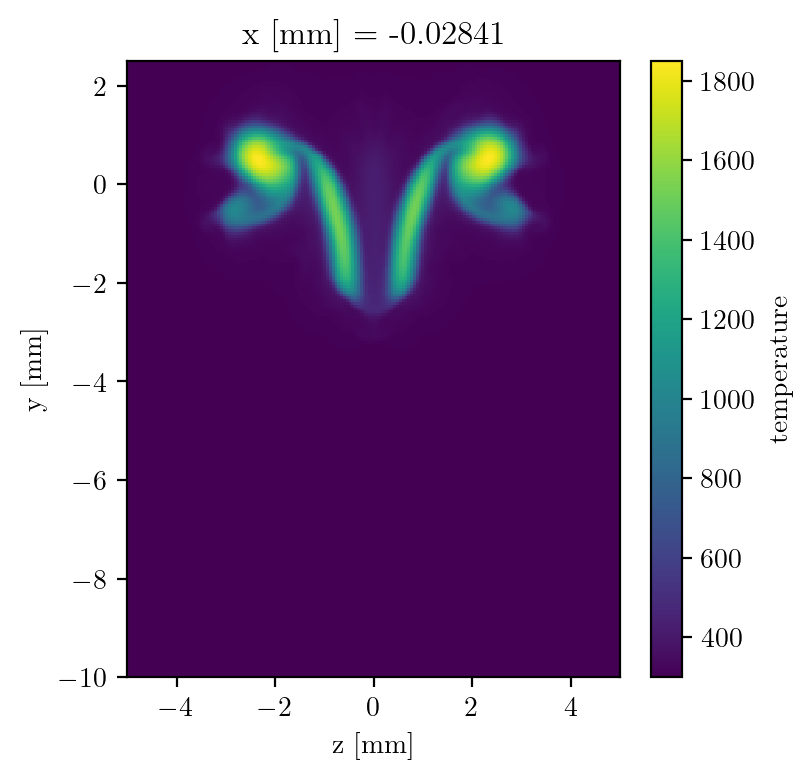

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
data_array.isel({'x [mm]': 87}).plot(ax=ax)
ax.set_aspect('equal')

In [11]:
# LF data extraction functions

def extract_meta_df_lf(run_dirs: list) -> pd.DataFrame:

    rows = []

    for run_dir in run_dirs:
        print(run_dir)
        laser_fwhm = extract_laser_fwhm(run_dir / 'GG-combustor.json')
        near_radius, far_radius, axial_length = extract_laser_geometry(run_dir / 'GG-combustor.json')
        alpha = axial_length / (2 * near_radius)
        beta = near_radius / far_radius

        for run in run_dir.glob('*.npz'):
            snapshot_ind = extract_snapshot_ind(run)
            sim_time = extract_sim_time_lf(run_dir, snapshot_ind)
            rows.append({
                'run_dir': run,
                'sim_time': sim_time,
                'laser_fwhm': laser_fwhm,
                'near_radius': near_radius,
                'far_radius': far_radius,
                'axial_length': axial_length,
                'alpha': alpha,
                'beta': beta
            })

    # Set index to run_dir
    df = pd.DataFrame(rows)
    df.set_index('run_dir', inplace=True)
    return df

def extract_sim_time_lf(run_dir: pathlib.Path, snapshot_ind: int) -> float:
    """Return simulation time in microseconds
    """
    sim_time_path = run_dir / f'data_{snapshot_ind:05d}.npz'

    assert sim_time_path.exists(), f'File not found: {sim_time_path}'

    sim_time = np.load(sim_time_path)['simTime']
    sim_time *= 11.375  # Multiply by time scale to get units of [us]
    return sim_time


def extract_snapshot_ind(run_path: pathlib.Path) -> int:
    return int(run_path.stem.split('_')[-1])


In [12]:
# Next, do the same with a single LF, and see if we can get some side-by-side plots going
data_dir = pathlib.Path('/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling')
run_dirs = sorted(data_dir.glob('[0-9][0-9]'))
df_lf = extract_meta_df_lf(run_dirs)

print(f'Found {len(run_dirs)} runs in {data_dir}')
df_lf

/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/11
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/12
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/13
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/14
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/15
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/16
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/17
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/18
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/19
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/20
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/21
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/22
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/23
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/24
/Volumes/M

,sim_time,laser_fwhm,near_radius,far_radius,axial_length,alpha,beta
run_dir,,,,,,,
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10/data_00000.npz,0.0,0.001484,0.202966,0.127688,0.752210,1.853039,1.589554
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10/data_01000.npz,0.22749999999999457,0.001484,0.202966,0.127688,0.752210,1.853039,1.589554
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10/data_02000.npz,0.4549999999999853,0.001484,0.202966,0.127688,0.752210,1.853039,1.589554
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10/data_03000.npz,2.7300000000000417,0.001484,0.202966,0.127688,0.752210,1.853039,1.589554
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10/data_04000.npz,5.004999999999807,0.001484,0.202966,0.127688,0.752210,1.853039,1.589554
...,...,...,...,...,...,...,...
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/73/data_09000.npz,96.00499999999272,0.001194,0.233535,0.100570,0.758682,1.624346,2.322101
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/73/data_10000.npz,118.75500000000032,0.001194,0.233535,0.100570,0.758682,1.624346,2.322101
/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/73/data_11000.npz,141.50500000000793,0.001194,0.233535,0.100570,0.758682,1.624346,2.322101


In [13]:
test_filename_lf = df_lf.iloc[13, :].name

test_filename_lf

PosixPath('/Volumes/My Passport for Mac/laser_tuning/LF/hyperCubeSampling/10/data_13000.npz')

Focal location: [13.0175  7.9375  0.    ]
Temperature array shape: (172, 172, 79)


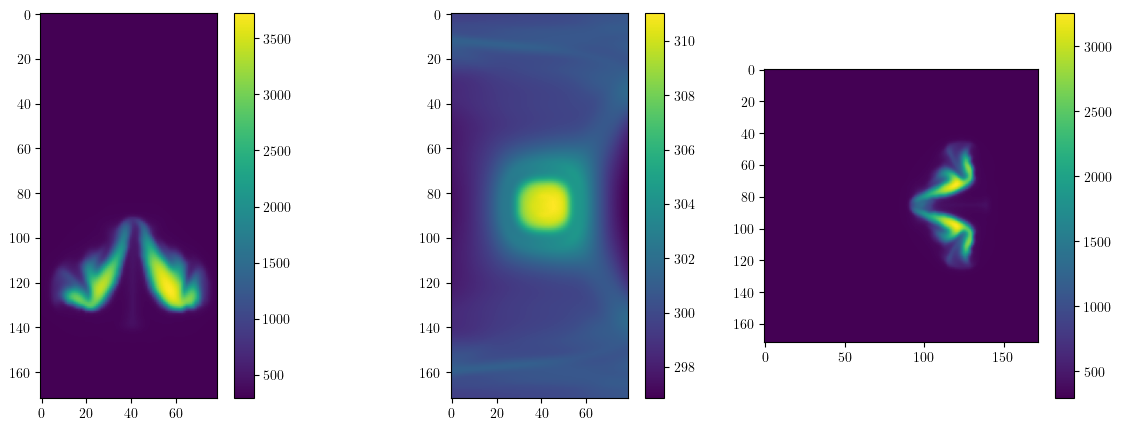

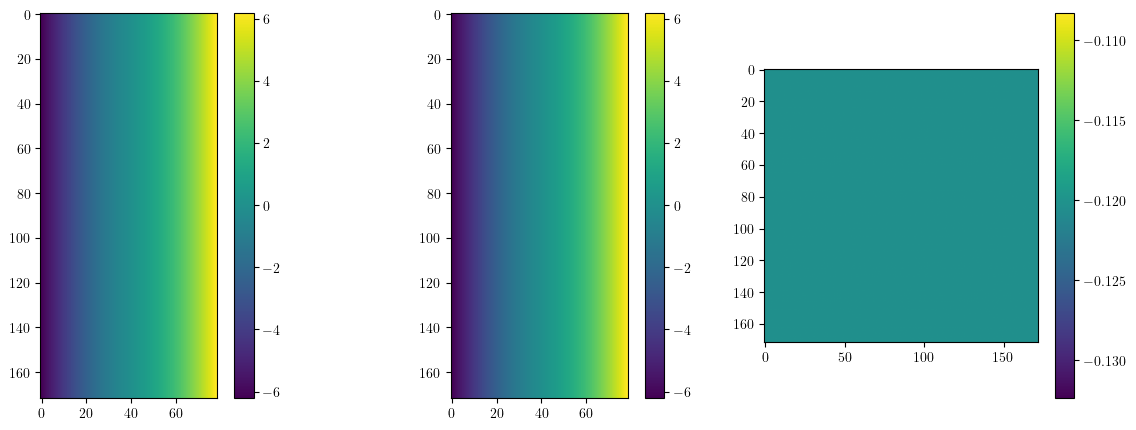

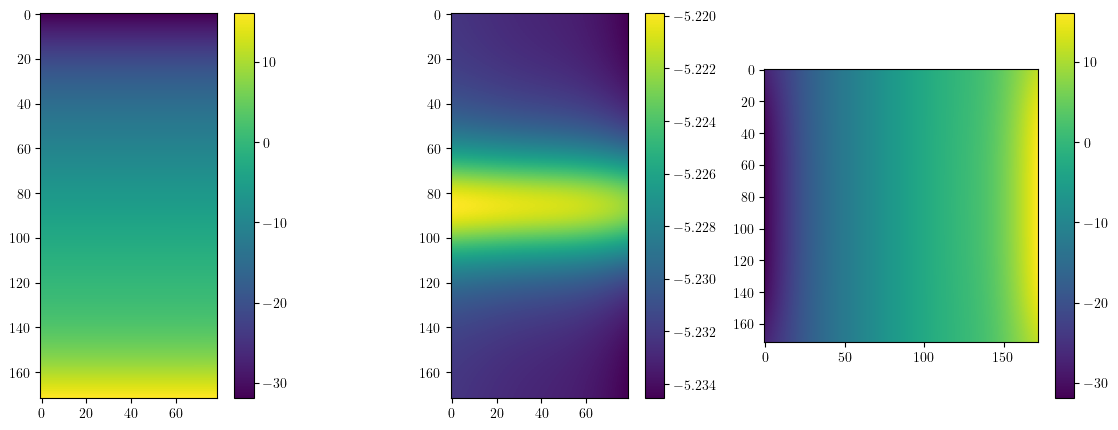

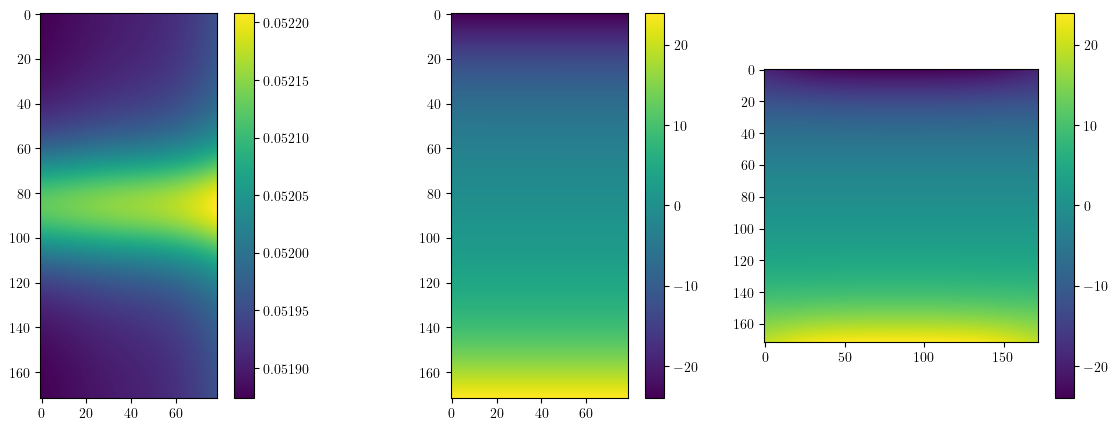

In [21]:
def extract_temp_arr_lf(run_name: pathlib.Path):
    data = np.load(run_name)
    return data['temperature'] * 300  # Multiply by temperature scale to get units of [K]

def extract_spatial_coords_lf(run_name: pathlib.Path):
    data = np.load(run_name)
    return data['position'] * 3.175  # Multiply by spatial scale to get units of [mm]

temp_arr_lf = extract_temp_arr_lf(test_filename_lf)
spatial_coords_lf = extract_spatial_coords_lf(test_filename_lf)
focal_location = extract_laser_focal_location(test_filename_lf.parent / 'GG-combustor.json') * 3.175

print(f"Focal location: {focal_location}")

spatial_coords_lf = spatial_coords_lf - focal_location

print(f"Temperature array shape: {temp_arr_lf.shape}")
plot_3_slice(temp_arr_lf)
plot_3_slice(spatial_coords_lf[:, :, :, 0])
plot_3_slice(spatial_coords_lf[:, :, :, 1])
plot_3_slice(spatial_coords_lf[:, :, :, 2])



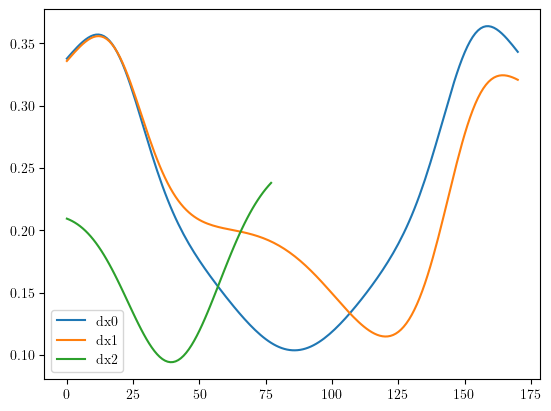

In [22]:
# Grid spacing
dx0s = np.diff(spatial_coords_lf[:, 0, 0, 2])
dx1s = np.diff(spatial_coords_lf[0, :, 0, 1])
dx2s = np.diff(spatial_coords_lf[0, 0, :, 0])

plt.plot(dx0s, label='dx0')
plt.plot(dx1s, label='dx1')
plt.plot(dx2s, label='dx2')
plt.legend()
plt.show()


In [23]:
spatial_coords_lf.min(axis=(0, 1, 2)), spatial_coords_lf.max(axis=(0, 1, 2))

(array([ -6.20749309, -31.89242349, -23.94890495]),
 array([ 6.18254849, 16.07299712, 23.94890495]))

In [17]:
lf_extents = spatial_coords_lf.max(axis=(0, 1, 2)) - spatial_coords_lf.min(axis=(0, 1, 2))

[100 150 100]


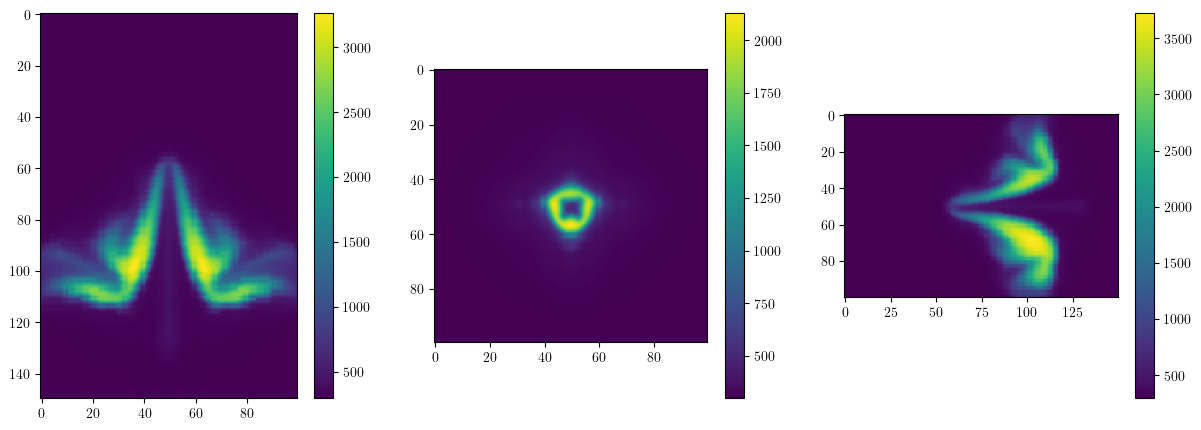

In [27]:
# So the LF data is on a curvilinear grid
# We need to resample this data onto a regular Cartesian grid before we can directly compare to HF data

from laser_tuning.src.utils.resampling import resample_point_cloud_to_regular_grid_2d

dx = 0.10
origin_coords = np.array([-5, -10, -5])
lf_extents[0] = 10
lf_extents[1] = 15
lf_extents[2] = 10  # Set z-extent to 10 mm
new_shape = (lf_extents / dx).astype(int)
print(new_shape)

xyz = spatial_coords_lf.reshape(-1, 3)
temp = temp_arr_lf.flatten()

temp_lf_resampled = resample_point_cloud_to_regular_grid_2d(xyz, temp, new_shape, lf_extents, origin_coords, method='nearest')

plot_3_slice(temp_lf_resampled)

In [28]:
write_isosurface_plot_from_arr(temp_lf_resampled, 'test_lf.png', 1000.0, False)

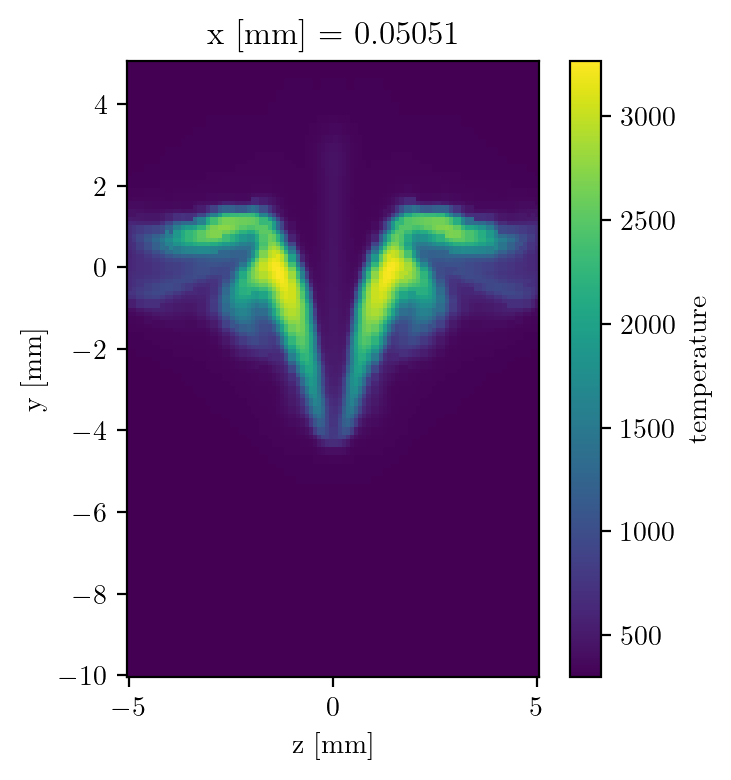

In [31]:
# Now we can create a DataArray for the LF data
x_coords_lf = np.linspace(origin_coords[0], origin_coords[0] + lf_extents[0], new_shape[0])
y_coords_lf = np.linspace(origin_coords[1], origin_coords[1] + lf_extents[1], new_shape[1])
z_coords_lf = np.linspace(origin_coords[2], origin_coords[2] + lf_extents[2], new_shape[2])

data_array_lf = xr.DataArray(
    temp_lf_resampled,
    coords={
        'x [mm]': x_coords_lf,
        'y [mm]': y_coords_lf,
        'z [mm]': z_coords_lf
    },
    dims=['x [mm]', 'y [mm]', 'z [mm]'],
    name='temperature'
)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
data_array_lf.isel({'x [mm]': 50}).plot(ax=ax)
ax.set_aspect('equal')


In [20]:
# Okay so we have centred the LF data and resampled onto a regular grid.
# Now we want to compare the two datasets side-by-side, so we need to set a common origin and extent, and then resample the HF and LF data into this frame.
# We can then compute various metrics. First step is to create functions which load the data appropriately, and then do the resampling.